<a href="https://colab.research.google.com/github/manuviani/CHAOS19_Biomedical_Segmentation_Challenge/blob/main/CHAOS19_Biomedical_Segmentation_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pydicom

In [3]:
from __future__ import print_function
import os
import glob
import skimage.io as io
import skimage.transform as trans
import numpy as np
import matplotlib.pyplot as plt
import cv2
import skimage
from PIL import Image
from pathlib import Path
import pydicom
from scipy.ndimage import zoom
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import random
from tqdm import tqdm
import shutil

import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as keras
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
import tensorflow_datasets



In [ ]:
!git clone https://github.com/manuviani/CHAOS19_Biomedical_Segmentation_Challenge.git

In [ ]:
%cd /content/CHAOS19_Biomedical_Segmentation_Challenge
!ls

## Parameters


In [4]:

DS_PATH='Data_Set/MR/'

# T1Spir Folders
#DICOM_PATH='/T2SPIR/DICOM_anon/'
#GROUND_PATH='/T2SPIR/Ground/'

# T2Dual Folders
DICOM_PATH='/T1DUAL/DICOM_anon/InPhase/'
GROUND_PATH='/T1DUAL/Ground/'



# Magnetic Resonance Patients Dataset
MR_Set= [1,2,3,5,8,10,13,15,19,20,21,22,31,32,33,34,36,37,38,39]



# greyscale range in ground truths
Liver=[55,70] #63
Right_kidney= [110,135] #126
Left_kidney = [175,200] #189
Spleen= [240,255] #252

GROUNDTRUTHS_RANGE = np.array([Liver, Right_kidney, Left_kidney, Spleen])


'''
#Color Dictionary

Liver=[128,128,128]
Right_kidney= [192,128,128]
Left_kidney = [192,192,128]
Spleen= [192,192,192]
Background = [0,0,0]

COLOR_DICT = np.array([Liver, Right_kidney, Left_kidney, Spleen, Background])
'''

# Data Split

TRAINING_PERCENT= 80
VALIDATION_PERCENT= 0
TESTING_PERCENT= 20

DATASET_SPLIT = np.array([TRAINING_PERCENT, VALIDATION_PERCENT, TESTING_PERCENT])

SPLIT_PATHS = np.array([
    'Data_Set/train/',
    '',
    'Data_Set/test/'
])


# Data Augmentation parameters
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=False,
                    fill_mode='nearest')


# numpy print options set to maximum
np.set_printoptions(threshold=os.sys.maxsize)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Helper Functions

## Import Functions

In [5]:

# IMPORT FUNCTIONS

def import_volume(patient): # return numpy array volume of one patient by stacking the dycom slices

    folder = DS_PATH + str(patient) + DICOM_PATH
    img_vol=[]
    for path, _, files in sorted(os.walk(folder)):
      for filename in (sorted(files)):
          if filename.endswith (".dcm"):
            #print (filename)
            img_dcm_std = pydicom.dcmread(os.path.join(folder,filename))
            #print(img_dcm_std)
            img = img_dcm_std.pixel_array
            img_vol.append (img)


    img_vol_raw = np.array (img_vol)


    maxval= np.amax(img_vol_raw)
    if maxval != 0:
      img_vol_raw = img_vol_raw / maxval * 255

    return img_vol_raw


def import_ground(patient): # return numpy array volume of one patient by stacking the ground truths (png)

    '''
    # Importing the segmentations from a spir folder of a patient of MR scans
    folder = DS_PATH + str(patient) + GROUND_PATH
    folder = Path(folder)
    file_list = list(folder.iterdir())

    ground_vol = [np.asarray(Image.open(mri_file)) for mri_file in file_list]

    '''

    folder = DS_PATH + str(patient) + GROUND_PATH
    ground_vol=[]
    for path, _, files in sorted(os.walk(folder)):
      for filename in (sorted(files)):
          if filename.endswith (".png"):
            #print (filename)
            ground = np.asarray(Image.open(os.path.join(folder,filename)))
            ground_vol.append (ground)


    ground_vol_raw = np.array (ground_vol)

    '''
    maxval= np.amax(ground_vol_raw)
    if maxval != 0:
      ground_vol_raw = ground_vol_raw / maxval * 255

    '''

    return ground_vol_raw




'\nvol = import_volume(10)[18]\nprint(np.amax(vol))\nvol1 = vol/np.amax(vol)\nprint(np.amax(vol1))\n\nvisualize([vol, vol1])\n'

## Visualization Functions

In [25]:

def visualize(display_list, title= ["Input Image", "True Mask", "Predicted Mask"]):
  plt.figure(figsize=(15, 15))


  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(display_list[i], cmap = 'gray')
  plt.show()


def visualize_vert(display_list, title= ["Input Image", "True Mask", "Predicted Mask"]):
  plt.figure(figsize=(15,15))
  while (len(display_list)%4 != 0):
    display_list.append(np.empty(shape=256))

  for i in range(len(display_list)):
      plt.subplot(len(display_list)//4, 4, i+1)
      try:
        plt.title(title[i])
        plt.imshow(display_list[i], cmap = 'gray')
      except:
        pass
  plt.show()


def visualize_slices(volume, lista, title="slice"):
  displaylist = []
  titlelist = []

  for i in range(lista[0], lista[1]):
    displaylist.append(volume[i,:,:])
    titlelist.append(title+str(i))
  visualize_vert(displaylist, titlelist)



def visualize_all_slices(volume, title="slice"):
  l = len(volume)
  a= l//12
  print(a)
  b= l%12
  print(b)
  for i in range(0, a):
    visualize_slices(volume, [12*i, 12*(i+1)], title)

  visualize_slices(volume, [12*(i+1), 12*(i+1)+b], title)



def display_learning_curves(history):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs_range = range(EPOCHS)

    fig = plt.figure(figsize=(12,6))

    plt.subplot(1,2,1)
    plt.plot(epochs_range, acc, label="train accuracy")
    plt.plot(epochs_range, val_acc, label="validataion accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower right")

    plt.subplot(1,2,2)
    plt.plot(epochs_range, loss, label="train loss")
    plt.plot(epochs_range, val_loss, label="validataion loss")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")

    fig.tight_layout()
    plt.show()


# Some Dataset Exploration

2
11


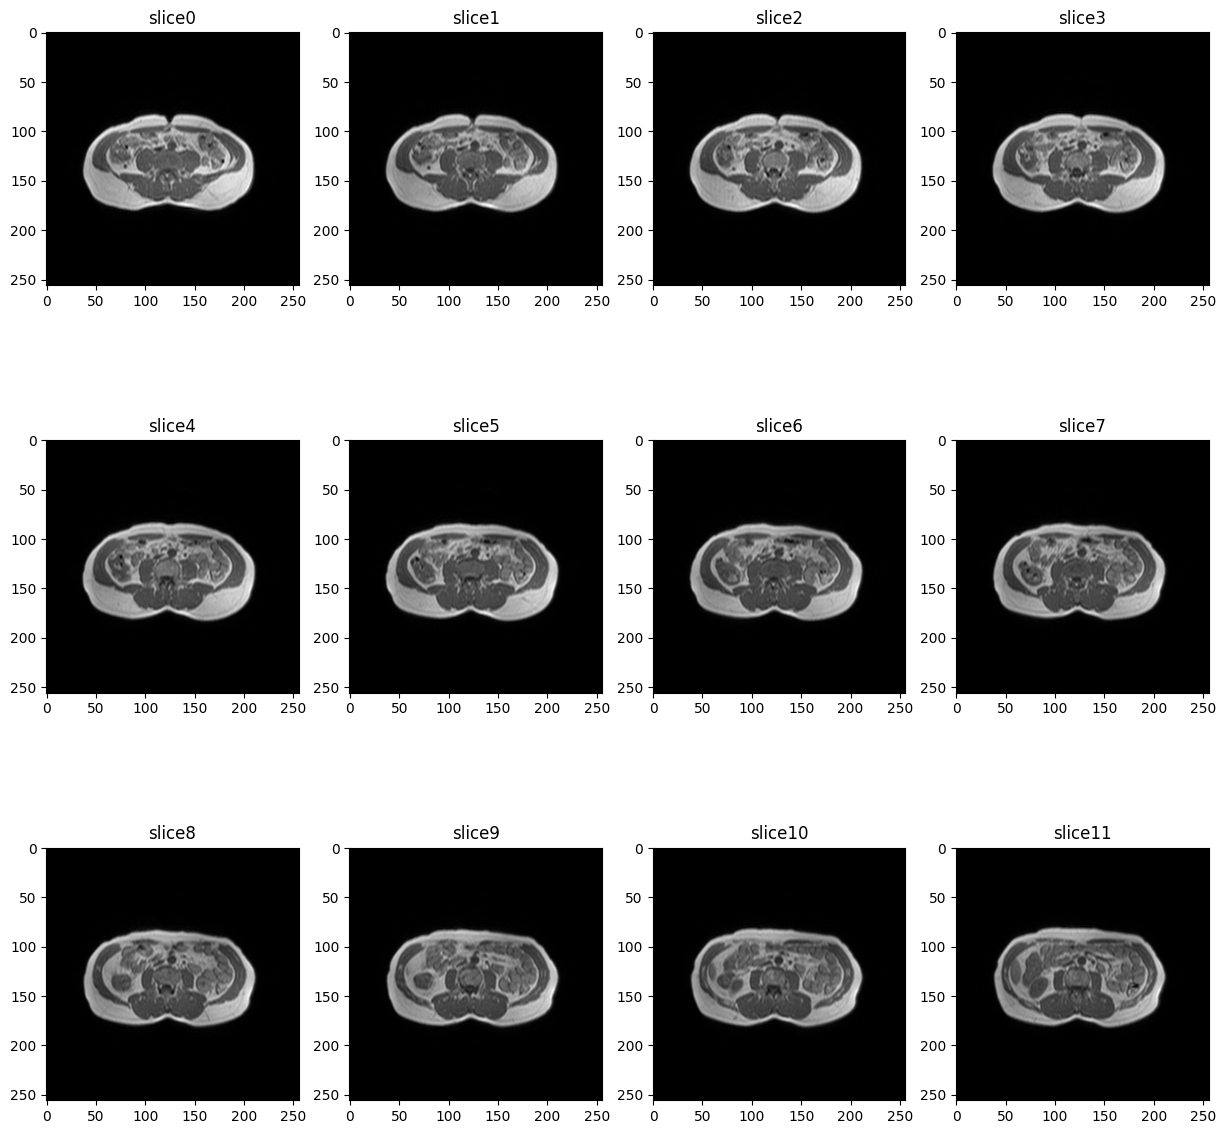

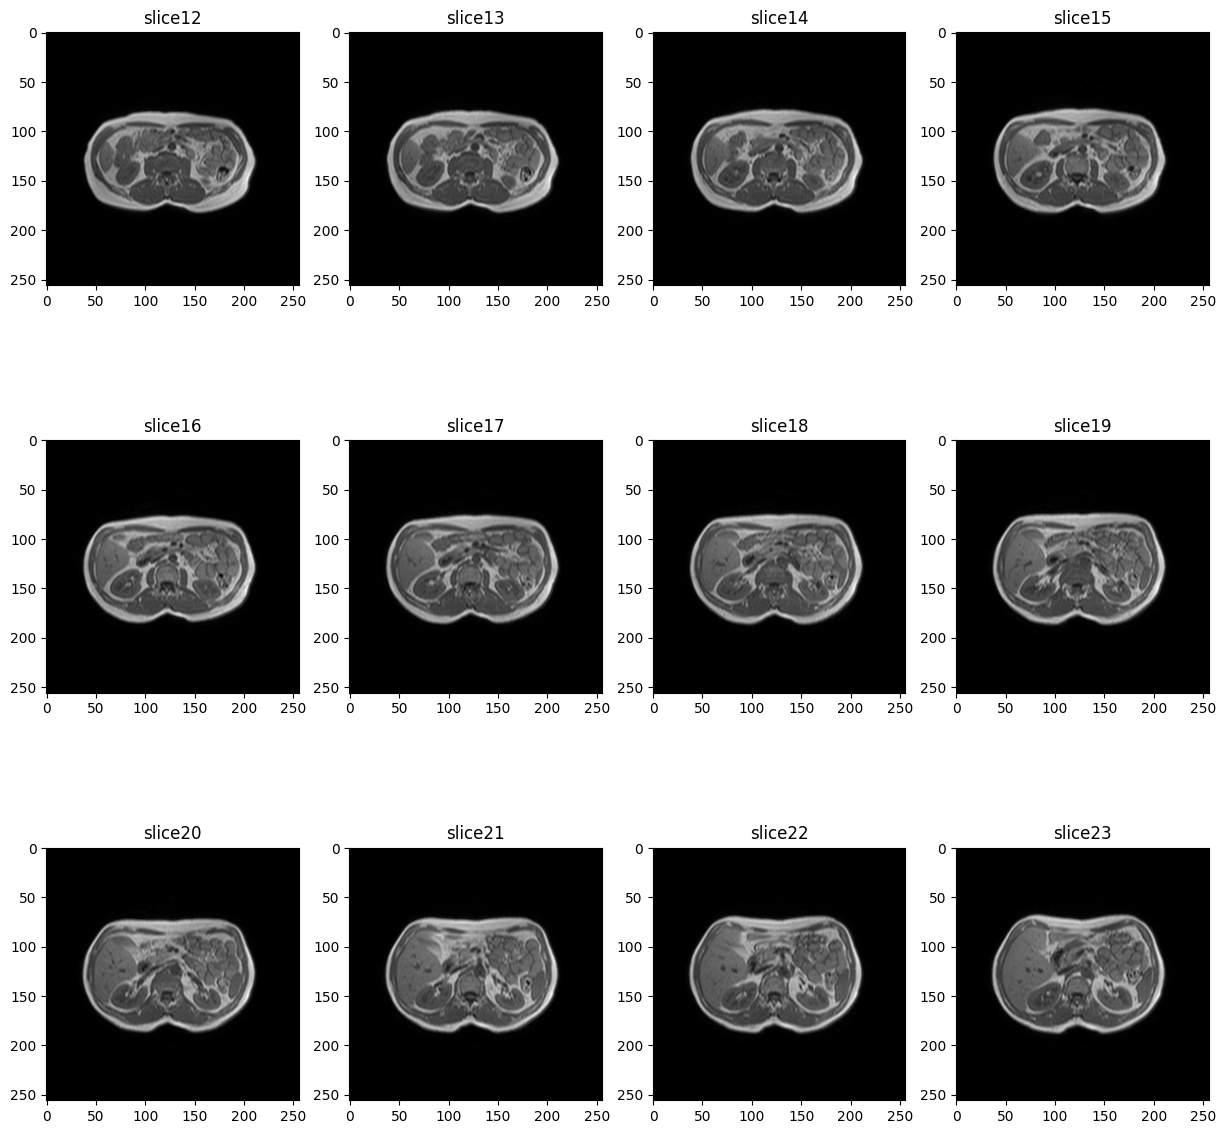

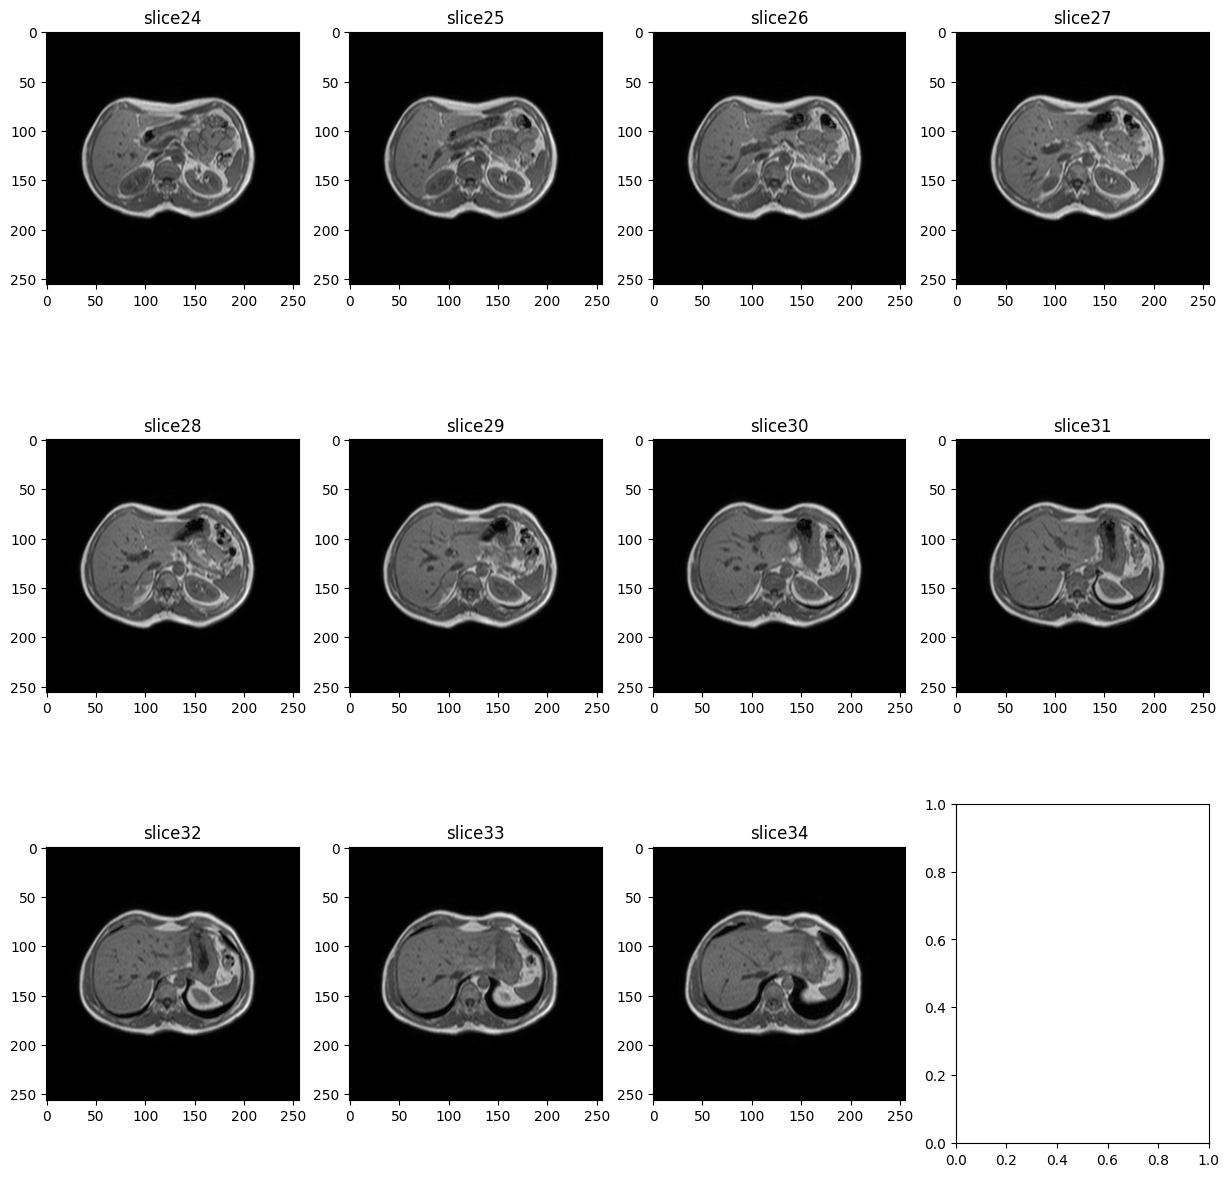

2
11


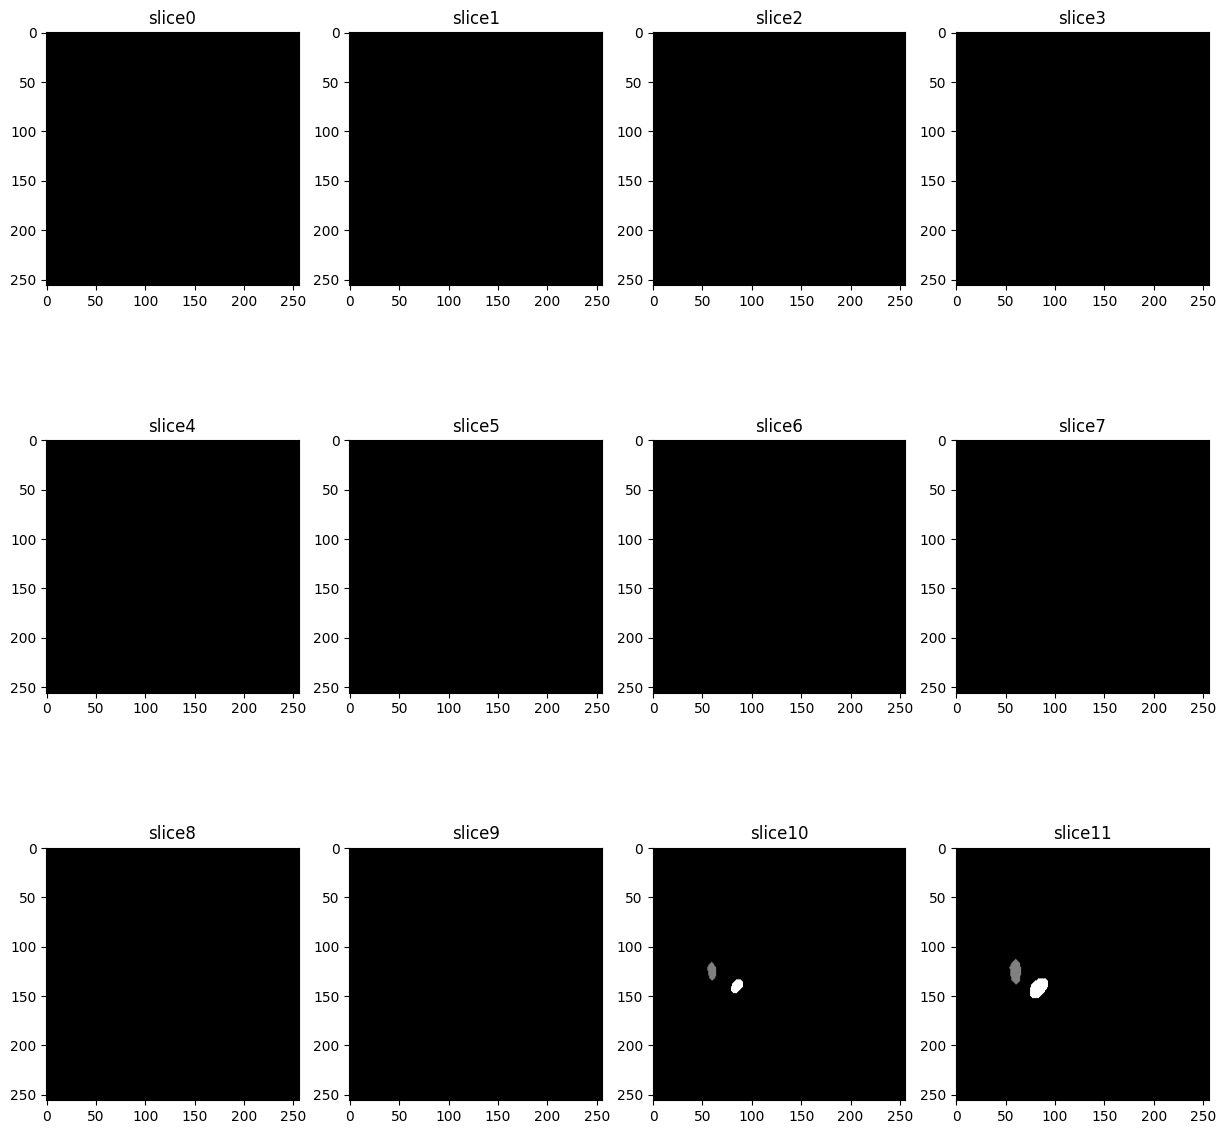

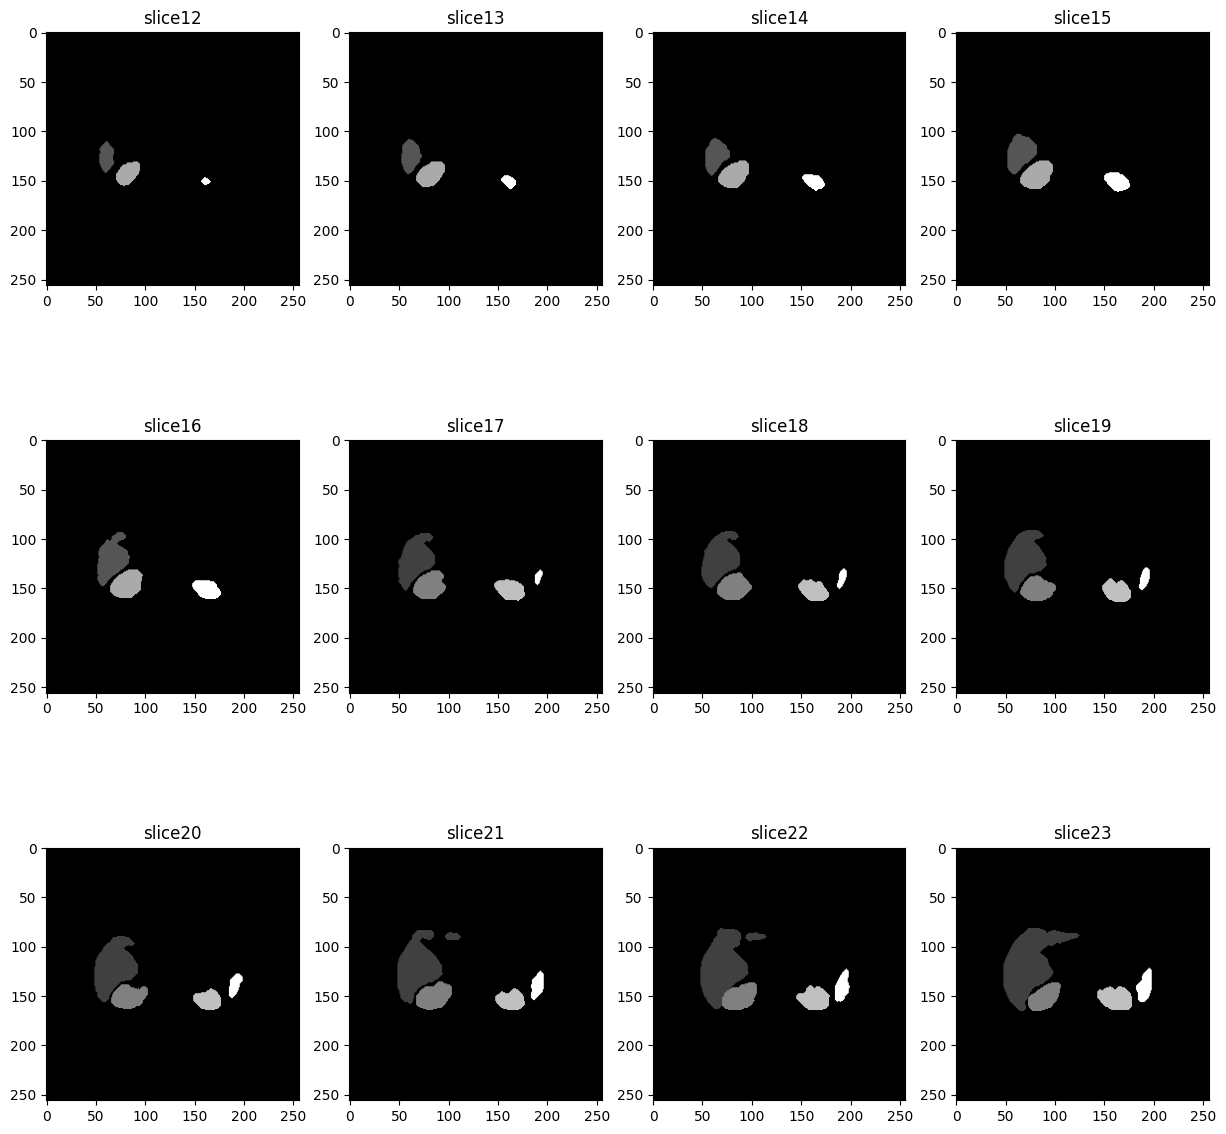

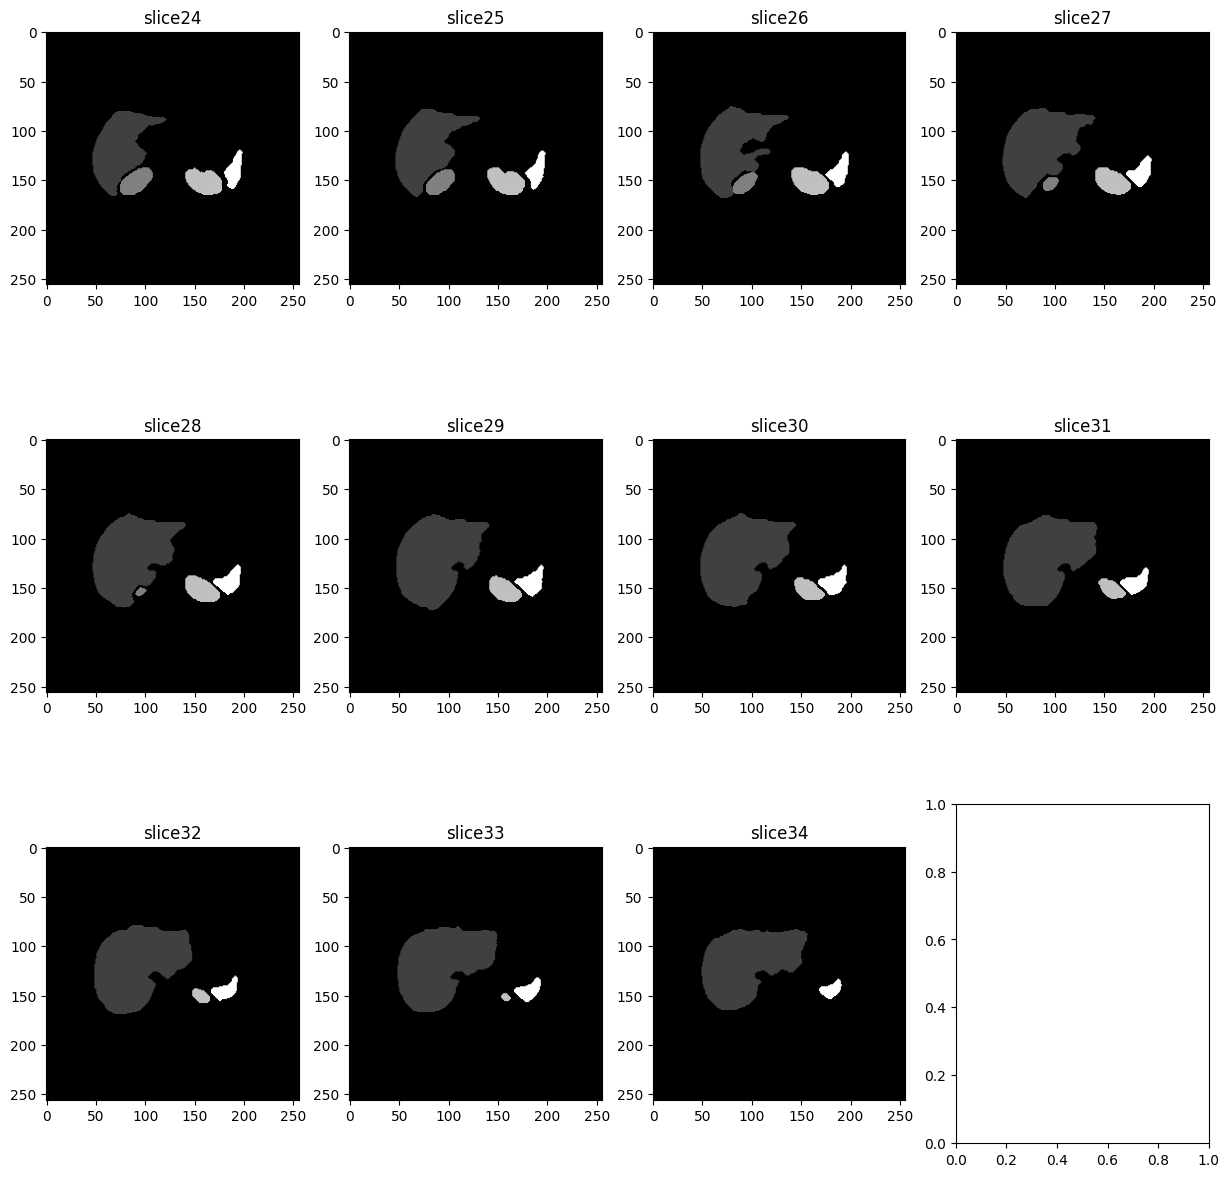

In [52]:
volume = import_volume(1)
mask = import_ground(1)
visualize_all_slices(volume)
visualize_all_slices(mask)

# Preprocessing

In [6]:
def resize(n, dim): # imports and resizes a whole volume and its ground truths

  # RESIZING DICOMS
  image_vol = import_volume(n)
  image_tensor = tf.convert_to_tensor(image_vol) # in order to use tf.image.resize() we have to convert np arrays in tf tensors
  image_tensor = tf.expand_dims(image_tensor, 3)
  resized_img = tf.image.resize(image_tensor, (dim, dim)).numpy()

  # RESIZING GROUND TRUTHS
  image_vol = import_ground(n)
  image_tensor = tf.convert_to_tensor(image_vol) # in order to use tf.image.resize() we have to convert np arrays in tf tensors
  image_tensor = tf.expand_dims(image_tensor, 3)
  resized_ground = tf.image.resize(image_tensor, (dim, dim)).numpy()

  a = [resized_img, resized_ground]
  return a



The following functions create a random split of the dataset using the percentages given in **Parameters** section

In [7]:

def random_split_dataset(perc_list, split_paths, vol_list):
  l = len(vol_list)
  vol_list=vol_list.copy()
  split_number=[]

  for perc in perc_list:
    split_number.append(int(l*perc/100))

  split = {
      '0': [],
      '1': [],
      '2': [],
  }

  for i in split_number:
    for j in range(i):
      #print(vol_list)
      ind = random.randint(0, len(vol_list)-1)
      split[str(split_number.index(i))].append(vol_list[ind])
      vol_list.pop(ind)

  return split



def savesplit(split):
  split = random_split_dataset(DATASET_SPLIT, SPLIT_PATHS, MR_Set)
  np.save('MyDrive/Data_Set/Training', np.asarray(split['0']))
  np.save('Data_Set/validation', np.asarray(split['1']))
  np.save('Data_Set/Testing', np.asarray(split['2']))



def loadsplit():
  train = np.load('Data_Set/Training.npy')
  val = np.load('Data_Set/validation.npy')
  test = np.load('Data_Set/Testing.npy')

  split =   split = {
        '0': train.tolist(),
        '1': val.tolist(),
        '2': test.tolist(),
    }

  return split


split = loadsplit()

'''
#Uncomment this to generate a new split
split = random_split_dataset(DATASET_SPLIT, SPLIT_PATHS, MR_Set)
savesplit(split)
'''

print("Training Patients: ", split['0'])
print("Validation Patients: ", split['1'])
print("TestingPatients: ", split['2'])



Training Patients:  [10, 33, 37, 5, 3, 1, 34, 36, 21, 13, 20, 38, 32, 8, 31, 22]
Validation Patients:  []
TestingPatients:  [39, 2, 15, 19]


In [8]:
def get_number(n):
  '''
  returns num padded with zeros
  '''
  out = "00000"

  out = out[len(str(n)):]
  out += str(n)
  return out


In [9]:
def normalize_mask(mask, r): # prepares the mask to be fed to the unet
    mask[(mask > r[0][0])&(mask < r[0][1])]=1   #Liver -> 1
    mask[(mask > r[1][0])&(mask < r[1][1])]=2   #Right_kidney -> 2
    mask[(mask > r[2][0])&(mask < r[2][1])]=3   #Left_kidney -> 3
    mask[(mask > r[3][0])&(mask < r[3][1])]=4   #Spleen -> 4

    mask[(mask != 1)&(mask != 2)&(mask != 3)&(mask != 4)]=0  #Everything else -> Background -> 0

    return mask


The following function processes the `T2SPIR/n/InPhase` folders and creates a `train` and `test` folder, each with `image` and `label` subfolders.

Every image will have the same name of its label

In [ ]:

def clean_dir():
  try:
    shutil.rmtree('Data_Set/train')
    shutil.rmtree('Data_Set/test')
  except:
    pass
# To generate a new split uncomment this to clear the train, test directories
#clean_dir()

In [13]:

def process_dataset(dataset_split, split_paths, patients_list, res_dim, split_given=0):

      # If the dataset is not given random_split_dataset() is called
      split_dict= random_split_dataset(dataset_split, split_paths, patients_list) if not split_given else split_given


      clean_dir()


      for key in split_dict.keys():
        vol_list = split_dict.get(key)
        #print(vol_list)

        for num in tqdm(vol_list):

        #num=1

          volume, masks = resize(num, res_dim)

          for i in range(len(volume)):
            slicee = volume[i]
            #visualize([slicee])
            #print(slicee)
            slicee = np.reshape(slicee, (res_dim,res_dim))
            slice_png=Image.fromarray(slicee.astype(np.uint8))
            Path(split_paths[int(key)]+"/image/"+str(num)).mkdir(parents=True, exist_ok=True)
            path = split_paths[int(key)]+"/image/"+str(num)+"/"+str(num)+"_"+get_number(i)+".png"
            #print(path)
            slice_png.save(path)
            #np.save(split_paths[i]+"vol_"+str(num)+"_"+str(slicee), slicee)


          for i in range(len(masks)):
            mask = masks[i]
            mask = np.reshape(mask, (res_dim,res_dim))
            mask = normalize_mask(mask, GROUNDTRUTHS_RANGE)
            mask_png=Image.fromarray(mask)
            Path(split_paths[int(key)]+"/label/"+str(num)).mkdir(parents=True, exist_ok=True)
            path = split_paths[int(key)]+"/label/"+str(num)+"/"+str(num)+"_"+get_number(i)+".png"
            #print(path)
            mask_png.convert('L').save(path)
            #np.save(split_paths[i]+"mask_"+str(vol_list[num])+"_"+str(slicee), slicee)



#process_dataset(DATASET_SPLIT, SPLIT_PATHS, MR_Set, 256, split_given=split)


100%|██████████| 16/16 [05:20<00:00, 20.04s/it]
0it [00:00, ?it/s]
100%|██████████| 4/4 [01:05<00:00, 16.47s/it]


# Import Dataset in Tensorflow Datsets (tfds)

In [ ]:
!pip install tensorflow_datasets==4.9.2

In [18]:
%cd /content/CHAOS19_Biomedical_Segmentation_Challenge/Data_Set/chaos_dataset
!tfds build
%cd ..

/content/drive/MyDrive/Data_Set/chaos_dataset
INFO[build.py]: Loading dataset  from path: /content/drive/MyDrive/Data_Set/chaos_dataset/chaos_dataset_dataset_builder.py
2023-12-22 12:03:14.654775: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-22 12:03:14.654835: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-22 12:03:14.656165: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-22 12:03:15.910713: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
INFO[dataset_info.py]: Load dataset info from /root/tensorflow_datasets/

In [19]:
dataset, info = tensorflow_datasets.load('chaos_dataset:1.0.0', with_info=True)

In [20]:
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (256, 256))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (256, 256))

  input_image, input_mask = normalize(input_image, input_mask)


  return input_image, input_mask


def normalize(input_image, mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  #input_mask -= 1



  return input_image, mask


In [21]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 10
BUFFER_SIZE = 2000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [22]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [23]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomContrast(0.02, seed=seed)
    self.augment_inputs = tf.keras.layers.RandomRotation(0.02, seed=seed)
    #self.augment_labels = tf.keras.layers.RandomFlip(mode="vertical", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels


train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    #.map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

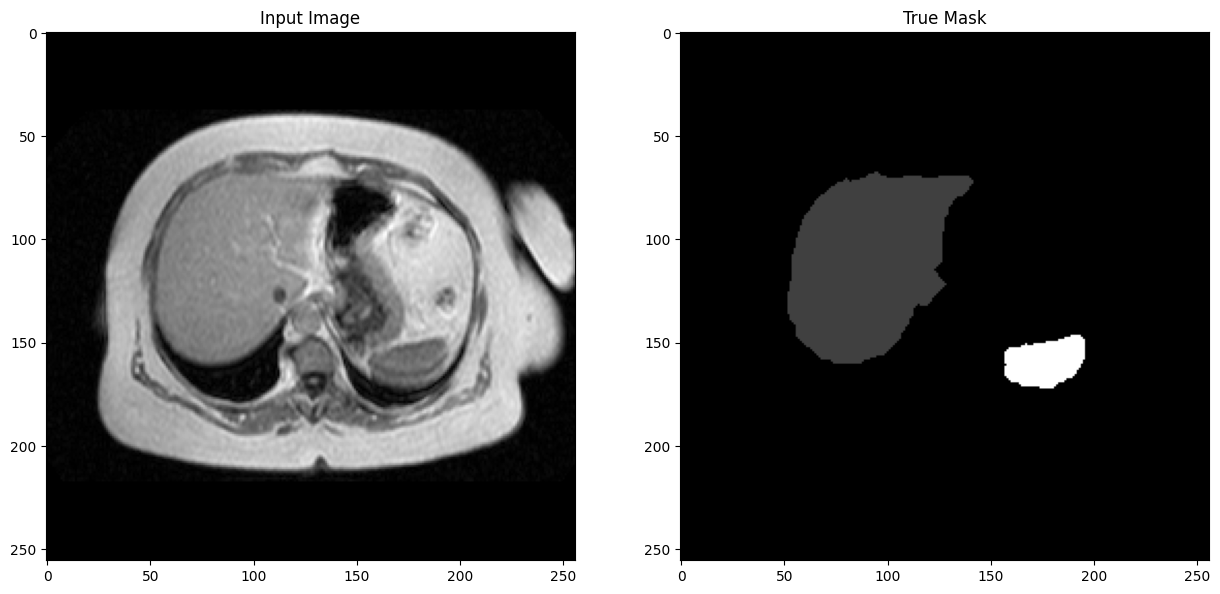

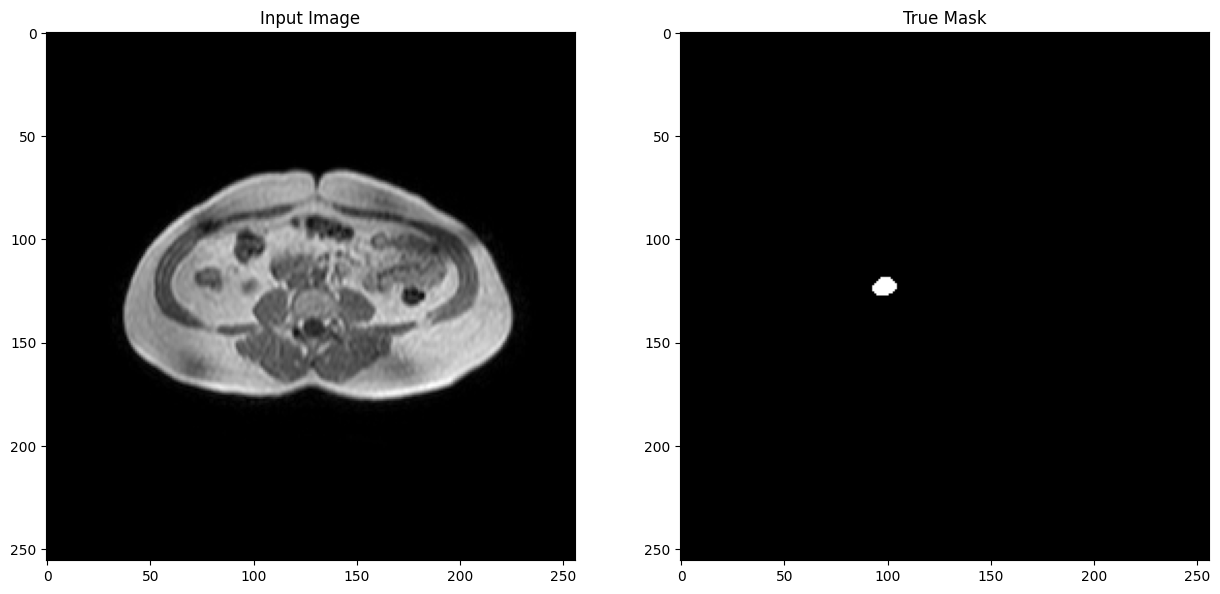

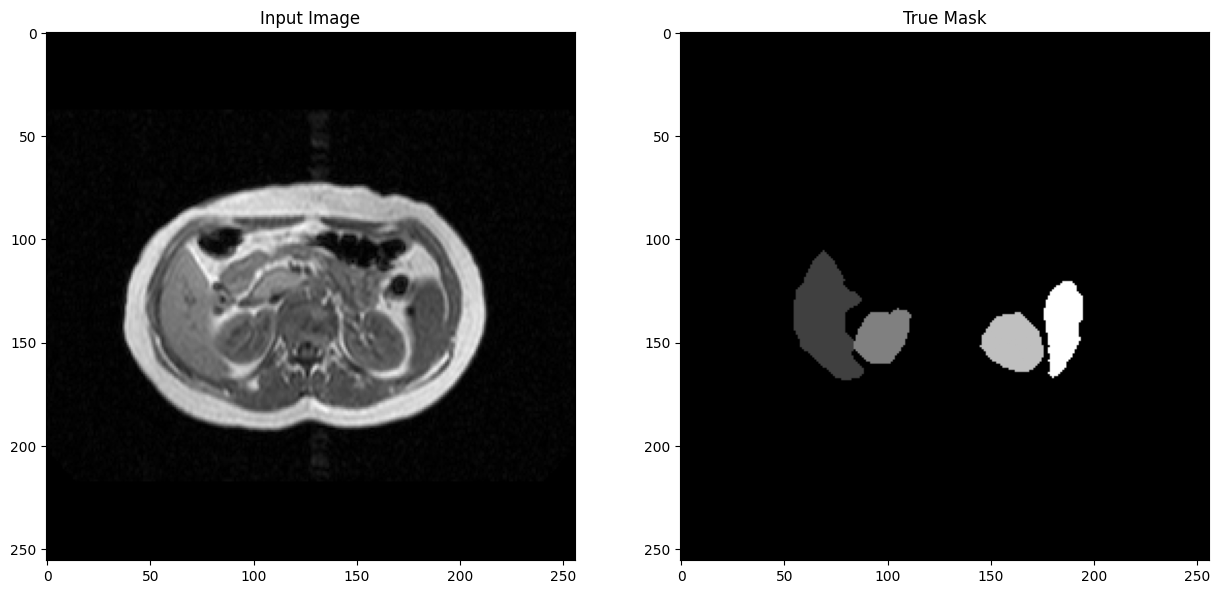

In [28]:
for images, masks in train_batches.take(3):
  sample_image, sample_mask = images[0], masks[0]
  visualize([sample_image, sample_mask])

#print(sample_image.shape)
#print(sample_mask.shape)

# Unet Model Function




In [29]:

def double_conv_block(x, n_filters):

    # Conv2D then ReLU activation
    x = Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    # Conv2D then ReLU activation
    x = Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

    return x


def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = MaxPool2D(2)(f)
    p = Dropout(0.3)(p)

    return f, p



def upsample_block(x, conv_features, n_filters):
    # upsample
    x = Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    # concatenate
    x = concatenate([x, conv_features])
    # dropout
    x = Dropout(0.3)(x)
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)

    return x





def build_unet_model(pretrained_weights = None, img_channel = 1, n_classes = 5):

    # INPUTS
    inputs = Input(shape=(256,256,img_channel))

    # ENCODER (4x Downsample)
    f1, p1 = downsample_block(inputs, 64)
    f2, p2 = downsample_block(p1, 128)
    f3, p3 = downsample_block(p2, 256)
    f4, p4 = downsample_block(p3, 512)

    # BOTTLENECK (2 x Convolution)
    bottleneck = double_conv_block(p4, 1024)

    # DECODER (4x Upsample)
    u6 = upsample_block(bottleneck, f4, 512)
    u7 = upsample_block(u6, f3, 256)
    u8 = upsample_block(u7, f2, 128)
    u9 = upsample_block(u8, f1, 64)

    # OUTPUTS
    outputs = Conv2D(n_classes, 1, padding="same", activation = "softmax")(u9)

    unet_model = tf.keras.Model(inputs, outputs)

    if(pretrained_weights):
        unet_model.load_weights(pretrained_weights)

    return unet_model

Let's plot unet's archietecture:

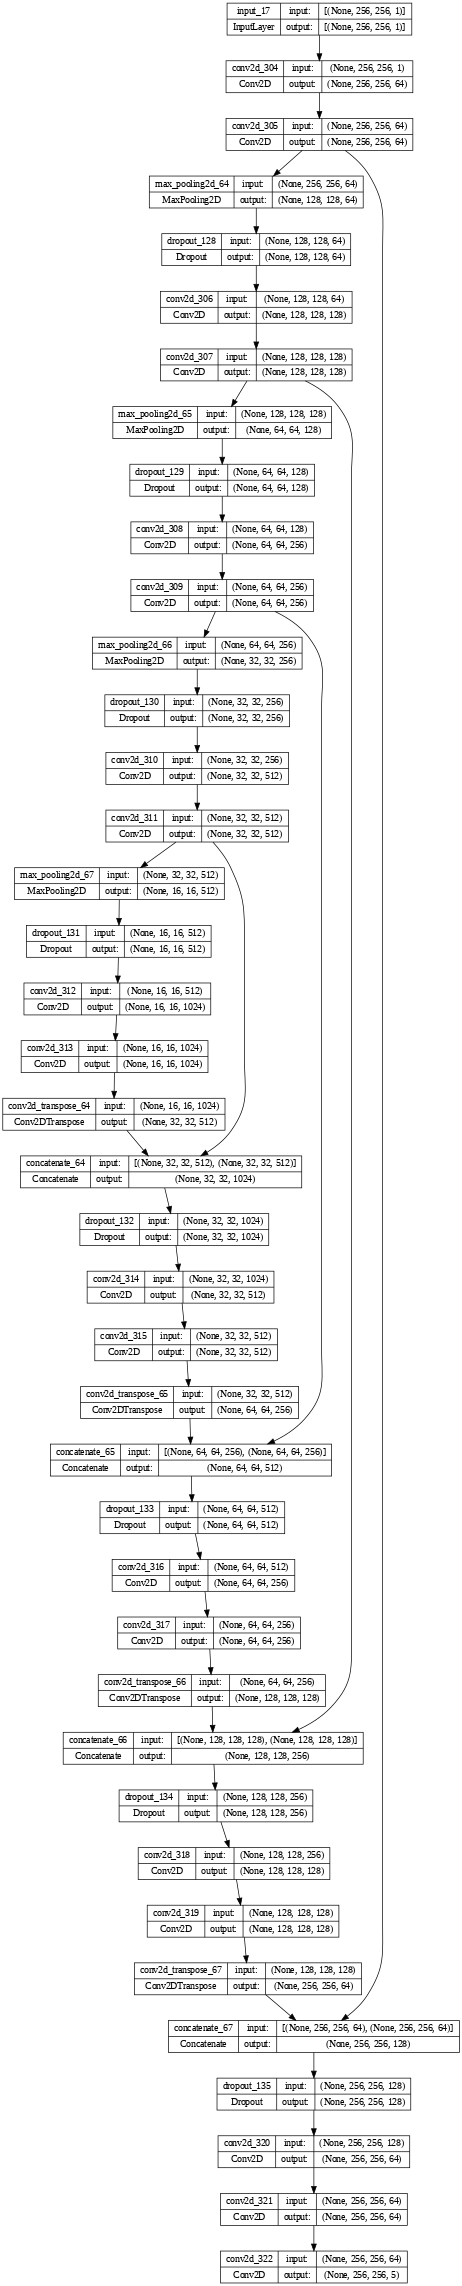

In [62]:
unet_model = build_unet_model()
#unet_model.summary()
tf.keras.utils.plot_model(unet_model, dpi=50,  show_shapes=True)

# Training

In [42]:
model = build_unet_model()
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

Functions used for visualizing results in training, validation and testing process:

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]


def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      visualize([image[0], image[0]+mask[0],mask[0], create_mask(pred_mask)],
       ["Input Image", "True Mask + Image","True Mask", "Predicted Mask"])
  else:
    predicted_mask = create_mask(model.predict(sample_image[tf.newaxis, ...]))
    visualize([sample_image, sample_mask + sample_image, sample_mask,
             predicted_mask ], ["Input Image", "True Mask + Image","True Mask", "Predicted Mask"])


class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    #clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))



The following function gives different optimization weights to the classes. This prevents the background

In [32]:
    # Background -> 0
    # Liver -> 1
    # Right_kidney -> 2
    # Left_kidney -> 3
    # Spleen -> 4


def add_sample_weights(image, label):

  class_weights = tf.constant([1.0, 10.0, 5.0, 5.0, 6.0])
  class_weights = class_weights/tf.reduce_sum(class_weights)


  sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))

  return image, label, sample_weights


train_batches.map(add_sample_weights).element_spec

(TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None))

In [ ]:
EPOCHS = 50
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS


model_checkpoint = ModelCheckpoint('chaos19_unet.hdf5', monitor='val_loss', verbose=1, save_best_only = True)
history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[model_checkpoint, DisplayCallback()])



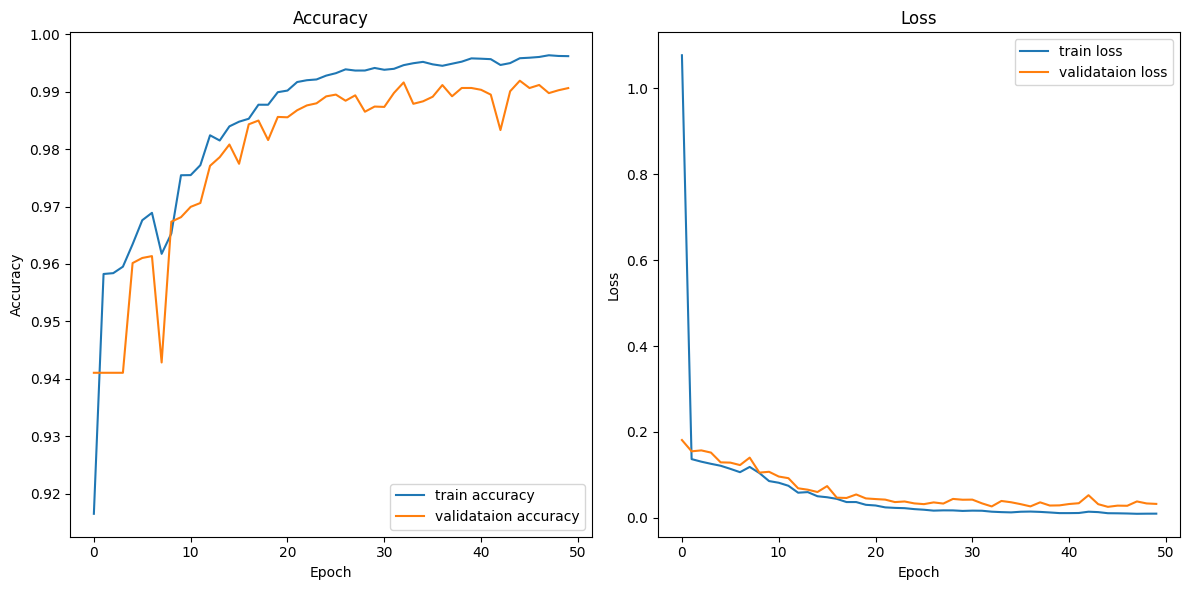

In [44]:
display_learning_curves(history)

# Testing

1/1 [==============================] - 0s 262ms/step


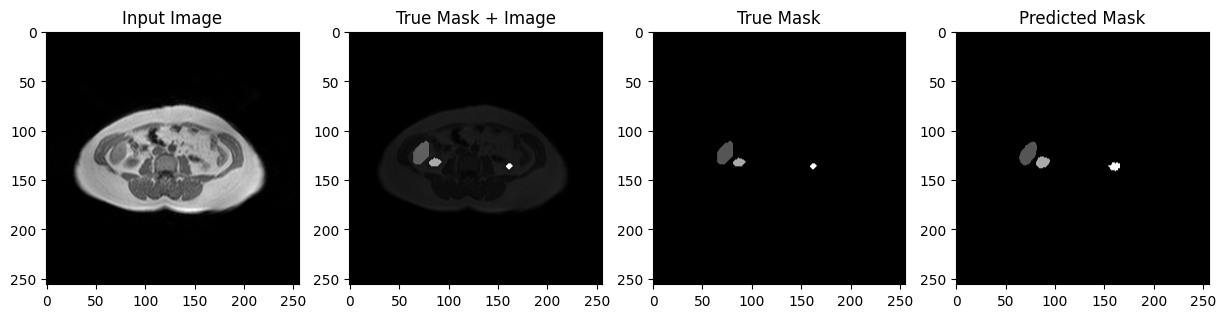

1/1 [==============================] - 0s 22ms/step


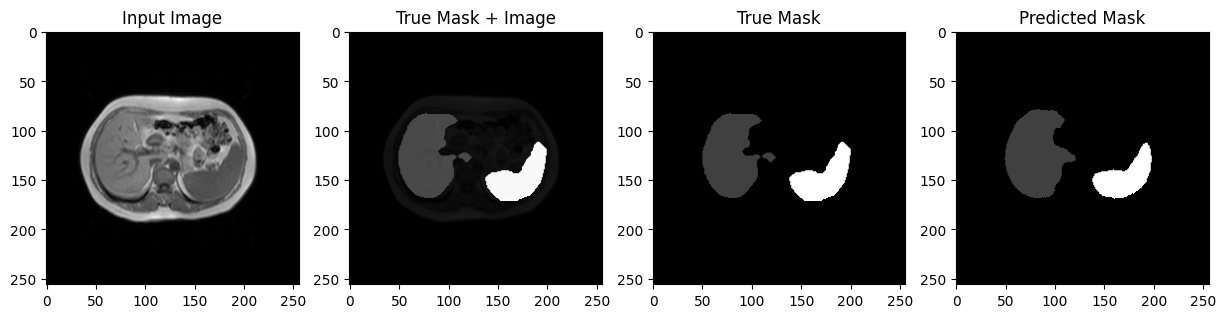

1/1 [==============================] - 0s 24ms/step


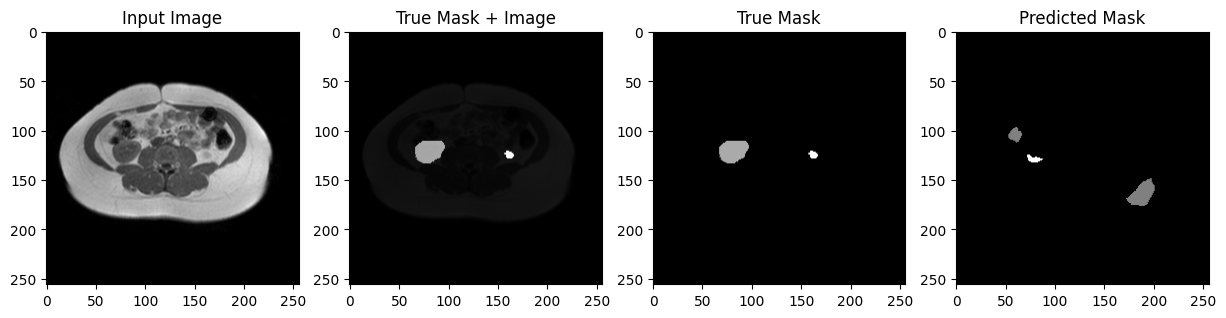

1/1 [==============================] - 0s 20ms/step


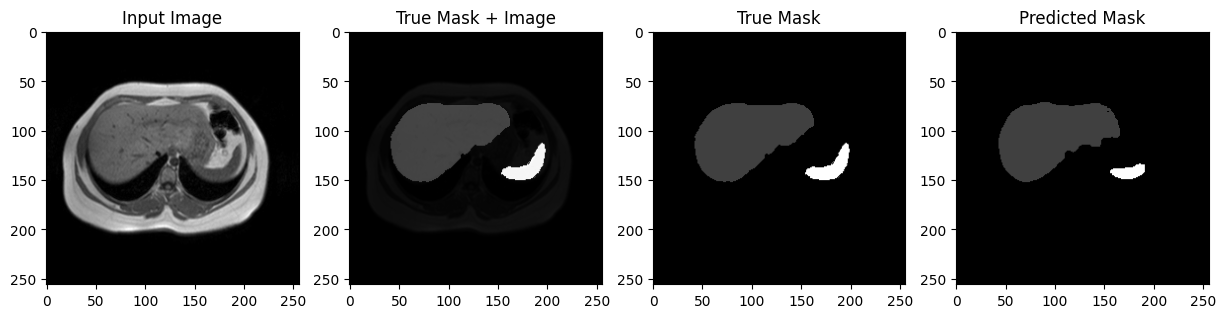

1/1 [==============================] - 0s 21ms/step


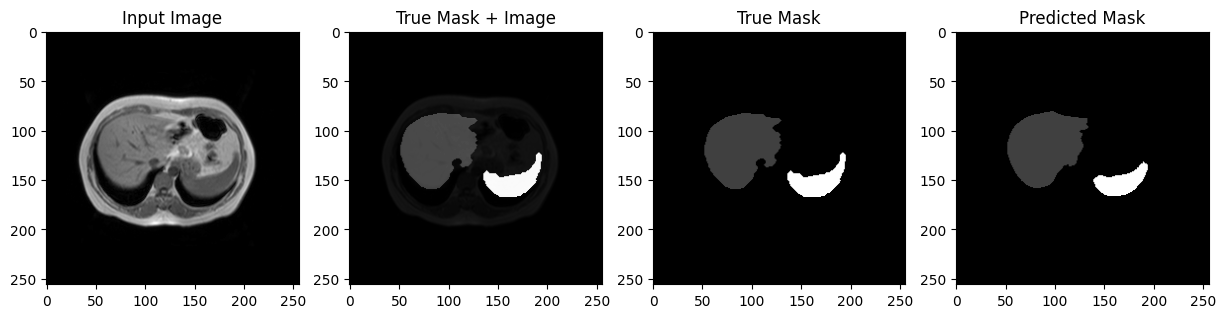

1/1 [==============================] - 0s 22ms/step


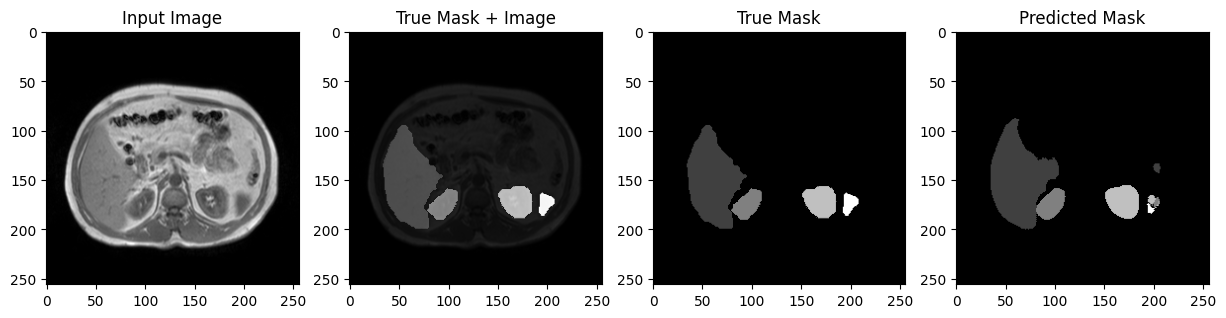

1/1 [==============================] - 0s 22ms/step


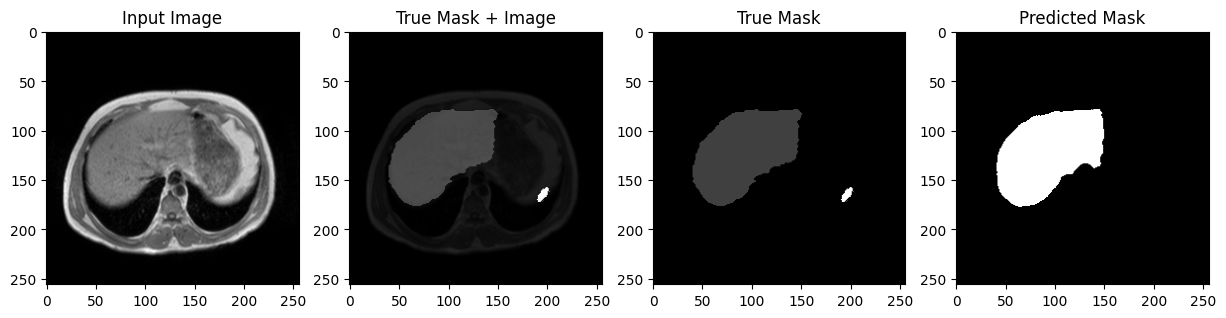

1/1 [==============================] - 0s 20ms/step


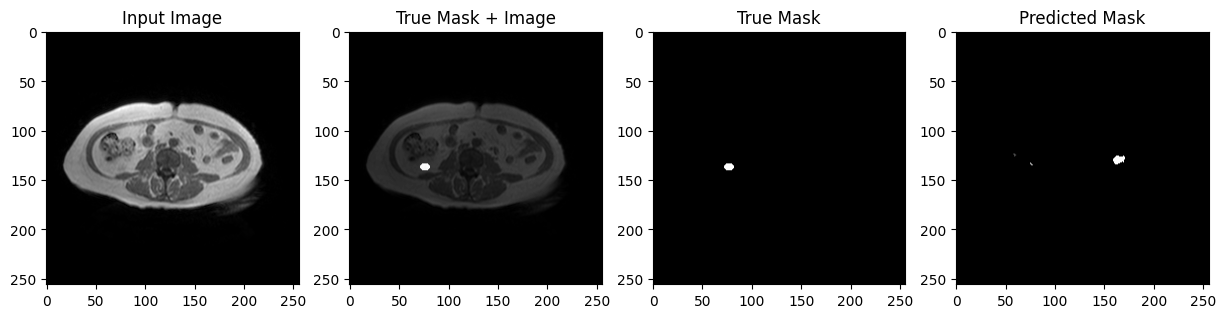

1/1 [==============================] - 0s 21ms/step


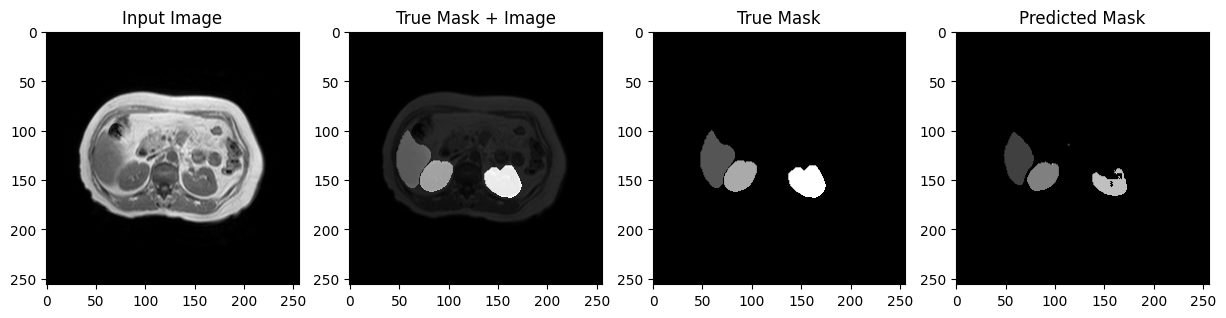

1/1 [==============================] - 0s 21ms/step


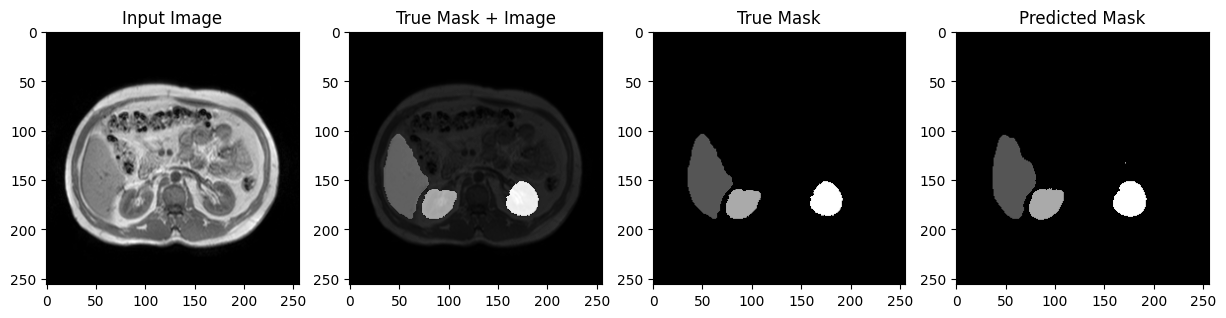

In [54]:
model = build_unet_model()
model.load_weights("chaos19_unet.hdf5")
show_predictions(test_batches, 10)